# Test selected features for predicting outcomes

In [29]:
from pathlib import Path
from itertools import product
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyreadstat

from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor

from hilda_config import release_suffix
from treatment_outcomes import compute_outcomes
from reed import drop_missing_treatment_or_outcome  #, Model, transform_outcome
from direct_regression import seperate_and_transform_data


%matplotlib inline

In [30]:
#log_outcome=False
#standardize_outcome=False
#exclude_patterns = [
#    '^reduhl$', '^rehllt$', '^redudl$', '^redufl$', '^redllt$', '^refllt$',
#    '^rlwage$', '^mh$', '^mhbm$', '^wkhr$', '^y_', '^p_rcom','^p_rdf','^p_cotrl',
#    '^xwaveid$','p_rcom18','^aedcq', '^abnfsty','^aedcqfpt','^aedqstdy'
#]
data_load_func = lambda filepath: pd.read_csv(filepath, index_col='xwaveid')

outcome = 'y_wscei'
treatment = 'redufl'
data_file_100 = Path("~/code/re-education/data/all_lasso_selected_100_restricted.csv")
data_file_all = Path("~/code/re-education/data/all_vars_restricted.csv")

## Load 2001 features, 100 selected and full set

In [31]:

data100 = data_load_func(data_file_100)

dataall = data_load_func(data_file_all)
_, _, _, _, Xall, _, _, featuresall = seperate_and_transform_data(dataall, treatment, outcome)
#drop_missing_treatment_or_outcome(data, treatment, outcome)
#data[outcome] = transform_outcome(data[outcome], log_outcome, standardize_outcome)

## Load 2006 targets

In [32]:
# read the combined file for 2006 wave
release = "restricted" # "restricted"
s,m,e = 'a','q','s' # select which waves to base analysis on
sfx = release_suffix[release]
indx = string.ascii_lowercase.index(s)+5
post_start = string.ascii_lowercase[indx]

df0, meta1 = pyreadstat.read_sav(f'data/part1/Combined {s}190{sfx}.sav') 
outcomes_post = compute_outcomes(df0, s, post_start, release)
outcomes_post['xwaveid'] = outcomes_post['xwaveid'].astype(int)
outcomes_post.set_index('xwaveid',inplace=True)

## Make common X, y data

In [33]:
common_ids = list(set.intersection(set(outcomes_post.index), set(data100.index)))
y06 = outcomes_post.loc[common_ids, outcome]
_, _, _, _, X100, y19, _, features100 = seperate_and_transform_data(data100.loc[common_ids], treatment, outcome)
_, _, _, _, Xall, _, _, featuresall = seperate_and_transform_data(dataall.loc[common_ids], treatment, outcome)

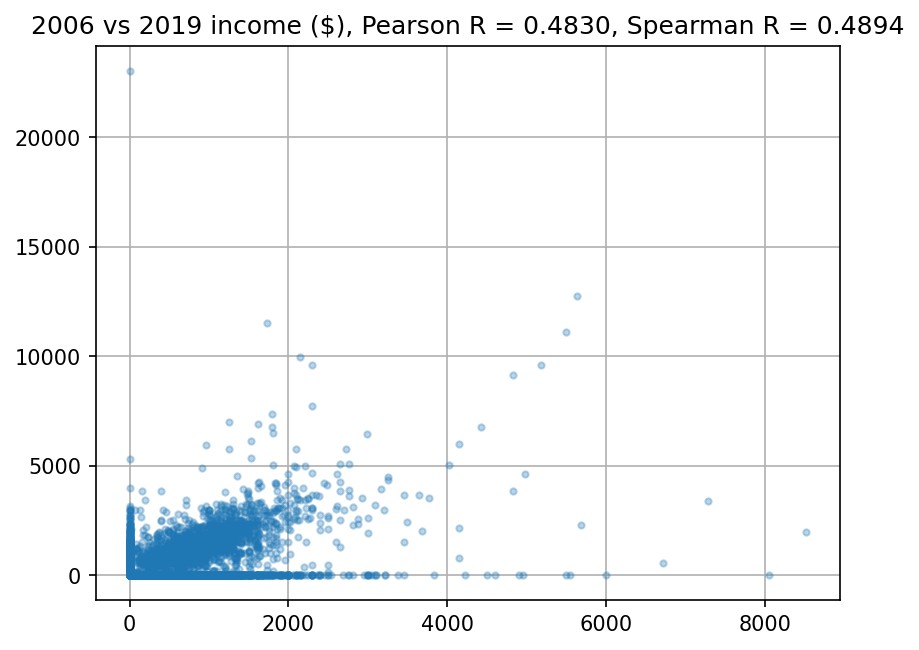

In [34]:
pr = pearsonr(y06, y19)
sr = spearmanr(y06, y19)
plt.figure(dpi=150)
plt.plot(y06, y19, '.', alpha=0.3)
plt.title(f"2006 vs 2019 income ($), Pearson R = {pr.statistic:.4f}, Spearman R = {sr.statistic:.4f}")
plt.grid()
plt.show()

## Machine learning models
Compare ML models for predicting 2006 vs 2019 outcomes using 100 and all features

In [35]:
cv = 5
model = GridSearchCV(
    LGBMRegressor(),
    param_grid={"learning_rate": [1e-2, 5e-2, 0.1, 0.5]},
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    cv=cv
) 

In [28]:
x_names = {"Selected": X100, "All": Xall}
y_names = {"2006 incomes": y06, "2019 incomes": y19}
scores = {}

for (xn, x), (yn, y) in product(x_names.items(), y_names.items()):
    print(f"{xn} and {yn}")
    score = cross_validate(
        model,
        X=x,
        y=y,
        scoring=["neg_mean_squared_error", "r2"],
        cv=cv
    )
    rmse = np.sqrt(- score["test_neg_mean_squared_error"])
    r2s = score["test_r2"] 
    scores[(xn, yn)] = rmse
    print(f" R2 = {r2s.mean():.3f} ({r2s.std():.3f})")
    print(f" RMSE = {rmse.mean():.3f} ({rmse.std():.3f})")

Selected and 2006 incomes
 R2 = 0.530 (0.041)
 RMSE = 484.251 (25.050)
Selected and 2019 incomes
 R2 = 0.352 (0.072)
 RMSE = 843.548 (117.371)
All and 2006 incomes
 R2 = 0.534 (0.036)
 RMSE = 482.286 (20.809)
All and 2019 incomes
 R2 = 0.370 (0.066)
 RMSE = 831.931 (116.115)


## Differences between "selected" and "all" features

In [36]:
def outer_diff_stats(x, y):
    diff = np.add.outer(x, -y)
    diff = diff[np.triu_indices(cv)]
    mdiff = diff.mean()
    sdiff = diff.std(ddof=1)
    return mdiff, sdiff

In [39]:
# Selected features
select_m, select_s = outer_diff_stats(scores[("Selected", "2006 incomes")], scores[("Selected", "2019 incomes")])
print(f"Selected features 2006 to 2019 RMSE difference = {select_m:.3f} ({select_s:.3f})")

# All features
all_m, all_s = outer_diff_stats(scores[("All", "2006 incomes")], scores[("All", "2019 incomes")])
print(f"All features 2006 to 2019 RMSE difference = {all_m:.3f} ({all_s:.3f})")

Selected features 2006 to 2019 RMSE difference = -329.313 (96.023)
All features 2006 to 2019 RMSE difference = -317.241 (93.496)
